# Differences over time

- Jacob Eisenstein, May 2019

Both academics and casual observers believe that politics in the USA has become more polarized. Can we see evidence of this in the language of American legislators? 

This notebooks builds on ideas from Monroe, Colaresi, and Quinn (MCQ) and [data from Gentzkow et al](https://data.stanford.edu/congress_text) to measure partisanship of individual words and track aggregate partisanship over time.
$
\newcommand{\yi}{y^{(i)}}
\newcommand{\yj}{y^{(j)}}
\newcommand{\ai}{\alpha^{(i)}}
\newcommand{\aj}{\alpha^{(j)}}
\newcommand{\ni}{n^{(i)}}
\newcommand{\nj}{n^{(j)}}
\newcommand{\oi}{o^{(i)}}
\newcommand{\oj}{o^{(j)}}
\newcommand{\fi}{f^{(i)}}
\newcommand{\fj}{f^{(j)}}
$

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from datetime import datetime

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

from tqdm import tqdm_notebook as tqdm

import os
from glob import glob
import pickle

basedir = os.path.join('..','data','same-diff-processed')

In [2]:
 # set to true if you want to recompute everything from scratch, and have access to the raw data
recomputing_all_data_files = False

## Data acquisition

In this project, we'll use data about U.S. Congressional floor speeches from Gentzkow et al. It's kind of big, so we'll start with data from a single session.

1. If you haven't already done so, get the raw data from the [bitbucket](https://bitbucket.org/jacobeisenstein/language-change-tutorial-data/src/master/), e.g., by running
```
git clone https://bitbucket.org/jacobeisenstein/language-change-tutorial-data.git
```
2. Uncompress the data for this notebook
```
cd language-change-tutorial-data
tar xvzf same-diff-data.tgz
```
3. Move (or link) the folder into `data`, or redefine `basedir` above.
```
cd ../data
ln -s ../language-change-tutorial-data/same-diff-processed
```

In [3]:
df_description = pd.read_csv(os.path.join(basedir,'descr_114.txt'),delimiter='|')
df_speeches = pd.read_csv(os.path.join(basedir,'speeches_114.txt'),delimiter='|',
                          error_bad_lines=False,encoding='iso8859')
df_speakers = pd.read_csv(os.path.join(basedir,'114_SpeakerMap.txt'),delimiter='|')

b'Skipping line 81799: expected 2 fields, saw 3\n'


First let's identify all speeches by members of each political party. We'll do this by joining the speeches and party information.

In [4]:
df_speeches.head(3)

,speech_id,speech
0,1140000001,The Representativeselect and their guests will...
1,1140000002,As directed by law. the Clerk of the House has...
2,1140000003,Four hundred and one Represent ativeselect hav...


In [5]:
df_speakers.head(3)

,speakerid,speech_id,lastname,firstname,chamber,state,gender,party,district,nonvoting
0,114120480,1140000007,MCMORRIS RODGERS,CATHY,H,WA,F,R,5.0,voting
1,114118560,1140000009,BECERRA,XAVIER,H,CA,M,D,34.0,voting
2,114121890,1140000011,MASSIE,THOMAS,H,KY,M,R,4.0,voting


In [6]:
df_speech_by_party = pd.merge(df_speeches, df_speakers, on='speech_id')[['speech_id','speech','party']]

In [7]:
print(df_speech_by_party.shape)
df_speech_by_party.head(3)

(67970, 3)


,speech_id,speech,party
0,1140000007,RODGERS. Madam Clerk. it is an honor to addres...,R
1,1140000009,Madam Clerk. first I would like to recognize e...,D
2,1140000011,Madam Clerk. I present for election to the off...,R


Many of these utterances are legislative formalities, so let's focus on speeches that are at least 1000 characters long.

In [8]:
df_speech_by_party = df_speech_by_party.loc[df_speech_by_party['speech'].apply(lambda x : len(x) > 1000)]

In [9]:
print(df_speech_by_party.shape)
df_speech_by_party.head(3)

(25832, 3)


,speech_id,speech,party
0,1140000007,RODGERS. Madam Clerk. it is an honor to addres...,R
1,1140000009,Madam Clerk. first I would like to recognize e...,D
3,1140000013,Madam Clerk. I present for the election of the...,R


Now let's merge in the date information to create the final dataframe.

In [10]:
df = pd.merge(df_speech_by_party, df_description, on='speech_id')[['speech_id','speech','party','date']]

In [11]:
df.head(3)

,speech_id,speech,party,date
0,1140000007,RODGERS. Madam Clerk. it is an honor to addres...,R,20150106
1,1140000009,Madam Clerk. first I would like to recognize e...,D,20150106
2,1140000013,Madam Clerk. I present for the election of the...,R,20150106


### Preprocessing

For temporal analysis, we need to convert the date field from an integer to a datetime object. We'll do that using the python `datetime` package.

In [12]:
df['date'] = df['date'].astype('str')
df['date'] = df['date'].apply(lambda x : datetime(year=int(x[:4]),
                                     month=int(x[4:6]),
                                     day=int(x[6:])))

In [13]:
df['date'].head(3)

0   2015-01-06
1   2015-01-06
2   2015-01-06
Name: date, dtype: datetime64[ns]

Next, we need to convert the "speech" field into something that will be easier to handle. For now, we'll use a simple **bag-of-words** representation. The `scikit-learn` library provides a useful class for handling this preprocessing.

In [14]:
vect = CountVectorizer(max_features=10000)

In [15]:
## this will take a minute to run
# X = vect.fit_transform(df['speech'])
X = vect.fit_transform(df['speech'][:1000])

In [16]:
X

<1000x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 239465 stored elements in Compressed Sparse Row format>

The result is a sparse matrix, specifically a member of `scipy.sparse.csr_matrix`. The columns of this matrix are identified by the vectorizer's vocabulary:

In [17]:
{i:j for i,j in list(vect.vocabulary_.items())[:6]}

{'rodgers': 7591,
 'madam': 5085,
 'clerk': 1587,
 'it': 4462,
 'is': 4440,
 'an': 593}

In [18]:
# convenience
ivoc = {idx:word for word,idx in vect.vocabulary_.items()}

## Final data format

I have performed this preprocessing for all U.S. Congresses from the 98th to the 114th. The resulting data looks like this:

In [23]:
# load back that file, which you should have
df_agg = pd.read_csv(os.path.join(basedir,'aggregate-counts.csv'),
                     usecols=['word','date','d_count','r_count'],
                     parse_dates=['date'])
vect = pickle.load(open(os.path.join(basedir,'congress-vocab.pkl'),'rb'))
ivoc = {j:i for i,j in vect.vocabulary_.items()}

In [24]:
df_agg.head(3)

,date,word,d_count,r_count
0,1981-01-01,00,57,5
1,1981-01-01,000,229,139
2,1981-01-01,10,116,119


Let's check the number of unique dates and words.

In [27]:
T = len(df_agg['date'].unique())
V = len(df_agg['word'].unique())
print(f'V={V}, T={T}')

V=10000, T=407


Now we'll construct matrices containing the aggregate word counts for the two main political parties over time.

In [29]:
# word counts of Democrats
X_d = df_agg['d_count'].to_numpy().reshape(T, V)
# word counts of Republicans 
X_r = df_agg['r_count'].to_numpy().reshape(T, V)

## Baselines

We'll start by computing partisanship of individual terms across all sessions. Once we have an effective method, we'll move to the dynamic analysis. 

A simple baseline is to compare the **log odds ratios**:

$\begin{align}
\oi_{w} = &{} \fi_w / (1 - \fi_w)\\
r_w = &{} \log \oi_w - \log \oj_w,
\end{align}$

where $\fi_w$ is the frequency of word $w$ in group $i$. For rare words (which are most words), $r_w \approx \log \fi_w - \log \fj_w$, but we'll compute $r_w$ exactly anyway.

In [30]:
# let's get the most recent monthly counts as a numpy array 
counts = df_agg.loc[df_agg['date']==df_agg['date'].unique().max()][['d_count','r_count']].to_numpy().T

In [31]:
counts

array([[  0, 106,  40, ..., 295,   0,   0],
       [  0,  97,  64, ..., 160,   2,   1]])

In [32]:
smoothing = 1e-2 # zero counts arise because the vocabulary includes words that were introduced at other times
f = ((counts+smoothing).T / (V*smoothing + counts.sum(1))).T

In [33]:
# make sure the frequencies sum to 1 for each group
f.sum(1)

array([1., 1.])

In [34]:
log_odds_ratio = np.log(f[0,]/(1-f[0,])) - np.log(f[1,]/(1-f[1,]))

Let's examine this metric with a histogram.

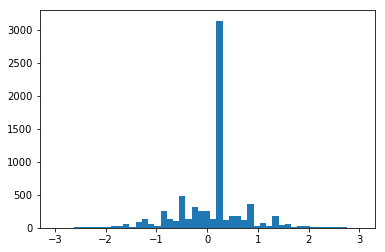

In [35]:
plt.hist(log_odds_ratio,np.linspace(-3,3));

As expected, the modal log odds ratio is $0$, corresponding to the case in which a word is equally likely in both groups.

Now let's look at the top words for each group by this metric.

In [36]:
print('R words:',[ivoc[i] for i in log_odds_ratio.argsort()[:10]])
print('D words:',[ivoc[i] for i in log_odds_ratio.argsort()[::-1][:10]])

R words: ['premiums', 'counties', 'option', 'alabama', 'premium', 'deductibles', 'heroin', 'arkansas', 'mandates', 'medal']
D words: ['statehood', 'loan', 'alzheimers', 'maryland', 'columbia', 'lee', 'generic', 'laos', 'borrowers', 'stock']


While some of these terms make sense, many are quite rare. Indeed, rare words tend to dominate the unsmoothed log odds ratio. This can be shown by a clever figure design by Monroe, Colaresi, and Quinn (MCQ 2009), whose paper is discussed below.

In [39]:
def make_word_importance_figure(scores, counts, ivoc, num_keywords = 20):
    fig = plt.figure(figsize=[12,6])
    ax = plt.gca()
    ax.plot(counts.sum(0), scores, '.', alpha=0.2, markeredgecolor='none', color='k')
    ax.set_xscale('log')
    plt.xlabel('count')
    plt.ylabel('score');
    for word_idx in scores.argsort()[:num_keywords]:
        plt.text(counts.sum(0)[word_idx], scores[word_idx], ivoc[word_idx], color='r')
    for word_idx in scores.argsort()[::-1][:num_keywords]:
        plt.text(counts.sum(0)[word_idx], scores[word_idx], ivoc[word_idx], color='b')
    
    # ranked order on the side
    all_words = [ivoc[idx] for idx in list(scores.argsort()[:num_keywords])]\
    + [' ']\
    + [ivoc[idx] for idx in list(scores.argsort()[::-1][:num_keywords][::-1])]

    y_min, y_max = ax.get_ylim()
    x_min, x_max = ax.get_xlim()
    _,_, x_extent_in_pixels, y_extent_in_pixels = ax.bbox.bounds
    y_vals_per_pixel = (y_max - y_min) / y_extent_in_pixels
    x_vals_per_pixel = (x_max - x_min) / x_extent_in_pixels
    
    for word, y_loc in zip(all_words, np.linspace(y_min, y_max - y_vals_per_pixel * 12, len(all_words))):
        ax.text(x_max + 24 * x_vals_per_pixel, y_loc, word)
    
    return ax

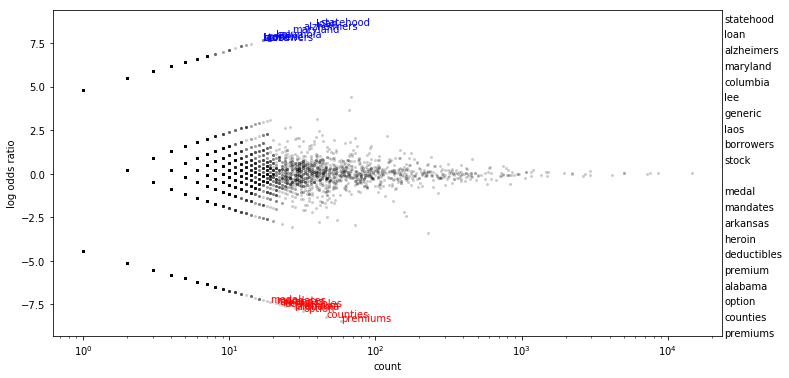

In [40]:
ax = make_word_importance_figure(log_odds_ratio, counts, ivoc, num_keywords=10)

ax.set_ylabel('log odds ratio');

Indeed, most of the top words are among the most rare, and this is unlikely to be a useful signal for temporal analysis. An elegant smoothing technique is offered by Monroe et al 2009, in their paper 'Fightin\' words'.

## Fightin words

$\newcommand{\yi}{y^{(i)}}
\newcommand{\yj}{y^{(j)}}
\newcommand{\ai}{\alpha^{(i)}}
\newcommand{\aj}{\alpha^{(j)}}
\newcommand{\ni}{n^{(i)}}
\newcommand{\nj}{n^{(j)}}
$

Political scientists Monroe, Colaresi, and Quinn (MCQ 2009) present a range of techniques for identifying polarized terms and overall polarization. Here are some results from [their 2009 APSR paper](https://pdfs.semanticscholar.org/4d6c/6a8b0dbdcf055e39141f56cba8fdc59774de.pdf).

<!-- ![word polarization over time](figs/fightin-words-one-word.png =100x100) -->
<table>
<tr><td>
<img src="figs/fightin-words-one-word.png" style="width: 300px">
    </td>
    <td>
<img src="figs/fightin-words-overall.png" style="width: 300px">
    </td>
    </tr>
</table>

We will replicate these results using data from [Gentzkow et al](https://data.stanford.edu/congress_text).

## Log-odds ratio as a random variable

MCQ's method treats the log-odds ratio as a function of word frequency rates, which are themselves random variables.
For each word $w$ and group $i$, we draw the frequency $\fi$ from a Dirichlet prior. The counts are then drawn from a Multinomial with $\fi$ as a parameter.

\begin{align}
\fi_w \sim & \text{Dirichlet}(\ai_w)\\
\yi_w \sim & \text{Multinomial}(\fi_w).
\end{align}

### MAP estimate of the log-odds ratio
The maximum a posteriori (MAP) estimate of $\fi_w$  is $\hat{\fi_w} = \frac{\yi_w + \ai_w}{\sum_{j} \yj_w + \aj_w},$ with the prior $\ai_w$ acting as smoothing.

Plugging in the MAP estimate $\hat{\fi_w}$ into the log-odds ratio gives, 

$\begin{equation}
\hat{\delta}^{(i-j)}_{w} = \log \frac{\yi_{w} + \ai_{w}}{\ni + \ai_{0} - (\yi_{w} + \ai_{w})}
-
\log \frac{\yj_{w} + \aj_{w}}{\nj + \aj_{0} - (\yj_{w} + \aj_{w})},
\end{equation}$

where $\ni = \sum_w \yi_w$ and $\ai_{t0} = \sum_w \ai_{tw}$.



### Variance and Z-score
It is also possible to estimate the variance of $\hat{\delta}^{(i-j)}$ and to compute a $Z$-score $\zeta^{(i-j)}_w$: 

$\begin{align}
\sigma^2(\hat{\delta}^{(i-j)}_{tw}) \approx &{} \frac{1}{\yi_{tw} + \ai_{tw}} + \frac{1}{\yj_{tw} + \aj_{tw}}\\
\hat{\zeta}^{(i-j)}_{tw} = &{} \hat{\delta}^{(i-j)}_{tw} / \sqrt{\sigma^2(\hat{\delta}^{(i-j)}_{tw})}
\end{align}$

The $Z$-score is the number of standard deviations above or below the mean. Rare words will have high variance, and consequently will tend to have lower $Z$-scores.

### Prior distribution
While it is common to use an uninformative Dirichlet prior $\alpha_w = \alpha_0$, MCQ obtain best results using an **informative** Dirichlet prior,
$\begin{equation}
\ai_{w} = \alpha_0 \frac{y_{w}}{n},
\end{equation}$
which is proportional to the overall frequency. They set $\alpha_0 = 500$. 

## Replication

Now let's try to replicate the figures from MCQ.

In [41]:
a0 = 500 # dirichlet precision, from MCQ
prior = np.array(a0 * X.sum(0) / X.sum())[0] + 1e-3 # again, small smoothing required for zero counts

In [42]:
def get_log_odds_MAP(x_i, prior):
    return np.log(x_i + prior) - np.log(x_i.sum() + prior.sum() - x_i - prior)

In [43]:
lor = get_log_odds_MAP(counts[0,],prior) - get_log_odds_MAP(counts[1,],prior)
var_lor = 1./(counts[0,] + prior) + 1./(counts[1,] + prior)
z_lor = lor / np.sqrt(var_lor)

Let's wrap these computations into a function:

In [44]:
def get_lor_stats(counts, pseudo_counts = 500, minimum_prior = 1e-3):
    G,W = counts.shape
    
    assert(G==2) # only works for two groups
    
    prior = np.array(pseudo_counts * counts.sum(0) / counts.sum())[0] + minimum_prior
    lor = get_log_odds_MAP(counts[0,], prior) - get_log_odds_MAP(counts[1,],prior)
    var_lor = 1./(counts[0,] + prior) + 1./(counts[1,] + prior)
    z_lor = lor / np.sqrt(var_lor)

    return z_lor, var_lor, lor

In [45]:
z_lor, var_lor, lor = get_lor_stats(counts)

## Visualizing partisan differences
Now let's make the figure again, this time using the z-scores $\hat{\zeta}$

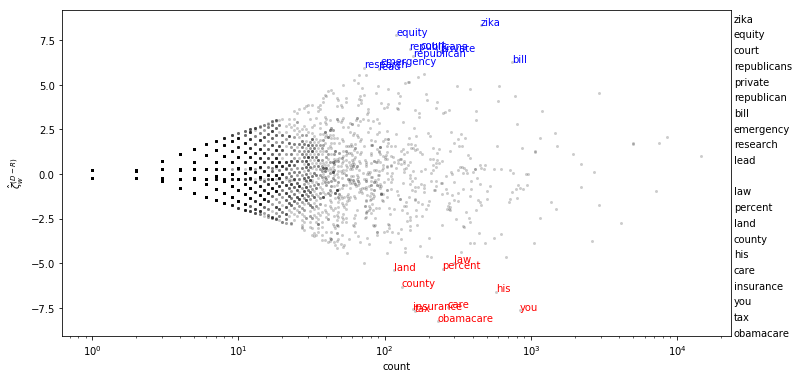

In [46]:
ax = make_word_importance_figure(z_lor, counts, ivoc, num_keywords=10)
ax.set_ylabel('$\hat{\zeta}^{(D-R)}_{w}$');
#ax.set_xlim(30,1e3);

This looks better, although it now overemphasizes common words like "his" and "bill". Tuning the prior $\alpha_0$ might help. MCQ get their best results by using a Laplace prior, which is equivalent to $L_1$ regularization of the log-odds ratio. However, this requires a more complex iterative estimation procedure, which does not easily scale to temporal analysis.

## Exercise

Create the same figure as above with different values of $\alpha_0$. Try to predict what will happen if you make $\alpha_0$ larger or smaller than the value above.

## Temporal analysis

MCQ show that the term "Iraq" changes partisan valence over time. Let's see if we can replicate their conclusions.

First we need to compute $\zeta^{(d-r)}_{tw}$ for all times $t$ and words $w$.

In [47]:
dates = []
words = []
zetas = []
for year_month in tqdm(sorted(df_agg['date'].unique())):
    counts = df_agg.loc[df_agg['date']==year_month][['d_count','r_count']].to_numpy().T
    z_lor, _, _ = get_lor_stats(counts)
    for idx,word in ivoc.items():
        #df_agg.loc[(df_agg['word']==word) & (df_agg['date']==year_month),'zeta'] = z_lor[idx]
        dates.append(year_month)
        words.append(word)
        zetas.append(z_lor[idx])
df_zeta = pd.DataFrame({'date':dates,'word':words,'zeta':zetas})

Now let's merge that back into our original data frame 


In [48]:
df_merged = pd.merge(df_agg, df_zeta, on=['word','date'])

In [49]:
df_merged.head(3)

,date,word,d_count,r_count,zeta
0,1981-01-01,00,57,5,4.553429
1,1981-01-01,000,229,139,1.751844
2,1981-01-01,10,116,119,-2.580214


To test this, let's plot $\hat{\zeta}$ for the term "Iraq".

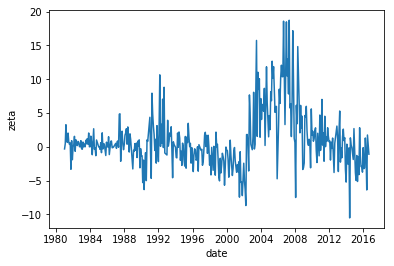

In [50]:
sns.lineplot(x='date',y='zeta',data = df_merged.loc[df_merged['word']=='iraq']);

Our figure matches the overall trend identified by MCQ, but their line was much smoother. They achieved this by applying an **exponentially weighted moving average** smoother to the word counts, before computing $\zeta$. Specifically, they first compute a 180-day moving average,

$\begin{equation}
m_{t,w} = \frac{1}{B} \sum_{b=0}^{B-1} x_{t-b,w},
\end{equation}$
where $B = 180$ days.

They then compute an exponentially weighted filter over these moving averages,

$\begin{equation}
\hat{x}_{t,w} = \alpha x_{t,w} + (1 - \alpha) \hat{x}_{t-1,w}.
\end{equation}$

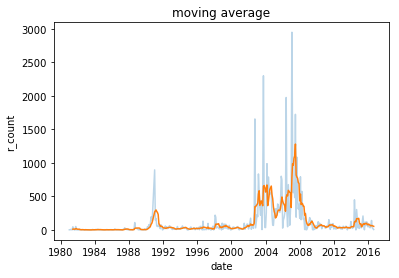

In [51]:
# original counts
s = df_merged.loc[df_merged['word']=='iraq','r_count']
sns.lineplot(y=s, x=df_merged.loc[df_merged['word']=='iraq','date'], alpha=0.3)

# 6-month moving average
m = s.rolling(6).mean() # rolling average over six month window
sns.lineplot(y=m, x=df_merged.loc[df_merged['word']=='iraq','date'])

plt.title('moving average');

### Choosing the filter decay

MCQ specify that $\alpha = 0.01$, but that's per day. 

We have to convert to per-month, while preserving the same "half-life."


In [52]:
alpha_per_day = 0.01
alpha_per_month = 1 - np.exp(np.log(1 - alpha_per_day) * 30)

In [53]:
print(f'alpha per month = {alpha_per_month:.3f}')
print(f'decay after six months = {(1-alpha_per_month)**6}')
print(f'decay after 180 days   = {(1-alpha_per_day)**180}')

alpha per month = 0.260
decay after six months = 0.1638079697080874
decay after 180 days   = 0.16380796970808742


## Plot with smoothing

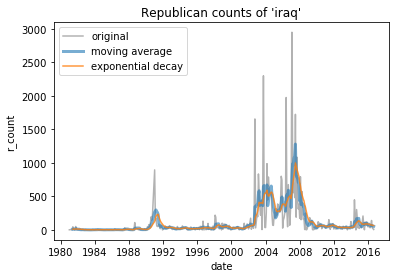

In [54]:
# original counts
s = df_merged.loc[df_merged['word']=='iraq','r_count']
x_series = df_merged.loc[df_merged['word']=='iraq','date']
ax = sns.lineplot(y=s, x=x_series, alpha=0.3,color='k')

# 6-month moving average
m = s.rolling(6).mean() # rolling average over six month window
#ax = m.plot(linewidth=3,alpha=0.6);
ax = sns.lineplot(y=m, x=x_series,linewidth=3, alpha=0.6)

m_ewm = m.ewm(alpha=alpha_per_month).mean()
ax = sns.lineplot(y=m_ewm, x=x_series,alpha=0.8)

#m.ewm(alpha=alpha_per_month).mean().plot(alpha=0.8)

ax.set_title('Republican counts of \'iraq\'')

ax.legend(['original','moving average','exponential decay']);

## Filtering all the words

Now we'll apply this filter to all counts in the data. This takes roughly 20-30 minutes on my laptop, so you can just load in the counts.

In [55]:
if recomputing_all_data_files:
    words = []
    dates = []
    filtered_counts = {'d_count':[],
                       'r_count':[]}
    for word in tqdm(df_agg['word'].unique()):
        df_word = df_merged.loc[df_merged['word']==word]
        words.extend(df_word['word'])
        dates.extend(df_word['date'])
        for count_group in ['d_count','r_count']:
            s = df_word[count_group]
            filtered = s.rolling(6).mean().ewm(alpha=alpha_per_month).mean()
            filtered_counts[count_group].extend(filtered)
    df_filtered = pd.DataFrame({'d_count':filtered_counts['d_count'],
                                'r_count':filtered_counts['r_count'],
                                'word':words,
                                'date':dates}).dropna()
    df_filtered.to_csv('aggregate-counts-smoothed.csv')
else:
    df_filtered = pd.read_csv(os.path.join(basedir,'aggregate-counts-smoothed.csv'), 
                              parse_dates=['date'],
                              usecols=['d_count','r_count','word','date'])

In [56]:
df_filtered.head(3)

,d_count,r_count,word,date
0,17.166667,13.333333,00,1981-06-01
1,12.759778,16.207391,00,1981-07-01
2,10.532655,15.970943,00,1981-08-01


### Zeta from smoothed counts

Now we will apply the same log-odds ratio computation from above, but use smoothed counts. For speed I have pre-computed all the smoothing.

In [57]:
if recomputing_all_data_files:     # takes roughly 1 minute on my laptop
    dates = []
    words = []
    zetas = []
    for year_month in tqdm(sorted(df_filtered['date'].unique())):
        counts = df_filtered.loc[df_filtered['date']==year_month][['d_count','r_count']].to_numpy().T
        z_lor, _, _ = get_lor_stats(counts)
        for idx,word in ivoc.items():
            #df_agg.loc[(df_agg['word']==word) & (df_agg['date']==year_month),'zeta'] = z_lor[idx]
            dates.append(year_month)
            words.append(word)
            zetas.append(z_lor[idx])
    df_zeta_filt = pd.DataFrame({'date':dates,'word':words,'zeta':zetas})
    df_zeta_filt.to_csv('zeta-filtered.csv')
else:
    df_zeta_filt = pd.read_csv(os.path.join(basedir,'zeta-filtered.csv'), 
                               parse_dates=['date'],
                               usecols=['zeta','word','date'])

In [58]:
df_zeta_filt.head(3)

,date,word,zeta
0,1981-06-01,mr,-1.053863
1,1981-06-01,president,-3.574481
2,1981-06-01,am,-1.268734


## Zeta over smoothed counts

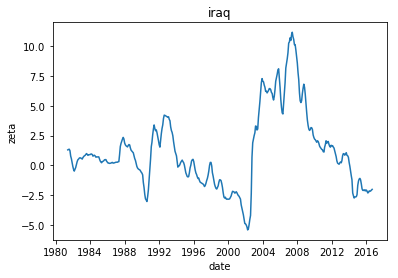

In [59]:
ax = sns.lineplot(x='date',y='zeta',data = df_zeta_filt.loc[df_zeta_filt['word']=='iraq'])
ax.set_title('iraq');

This looks pretty good! (Compare with the figure above from the paper.) Let's try a few others.

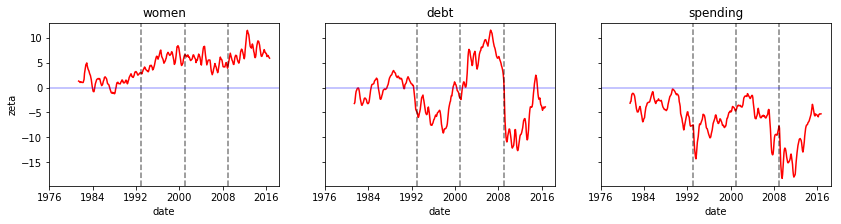

In [60]:
_, axes = plt.subplots(1,3,sharey=True,figsize=[14,3])
words = ['women','debt','spending']
for word, ax in zip(words, axes):
    sns.lineplot(x='date',y='zeta',data= df_zeta_filt.loc[df_zeta_filt['word']==word], ax = ax, color='r')
    ax.set_title(word)
    ax.axvline(datetime(year=1993,month=1,day=1),linestyle='--',color='k',alpha=0.5) # beginning of Clinton (D) presidency
    ax.axvline(datetime(year=2001,month=1,day=1),linestyle='--',color='k',alpha=0.5) # beginning of Bush II (R)
    ax.axvline(datetime(year=2009,month=1,day=1),linestyle='--',color='k',alpha=0.5) # beginning of Obama (D)
    ax.axhline(0,color='b',linestyle='-', alpha=0.3)
    ax.set_xticks(ax.get_xticks()[::2])

- The term "women" is generally associated with democrats, especially after 2000. 
- "spending" is associated with republicans, especially during the early part of the Obama presidency (2009).
- The term "debt" is preferred by out-of-power parties.

## Aggregate partisanship

MCQ measure overall partisanship at time $t$ by the variance of $\zeta_{tw}$ across words $w$. 

This is easy to compute in Pandas, using the `groupby` command:

In [61]:
var_zeta = df_zeta_filt.groupby(['date']).var()['zeta']

In [62]:
var_zeta.head(3)

date
1981-06-01    0.681973
1981-07-01    0.698495
1981-08-01    0.699963
Name: zeta, dtype: float64

Now we're ready to plot the aggregate partisanship.

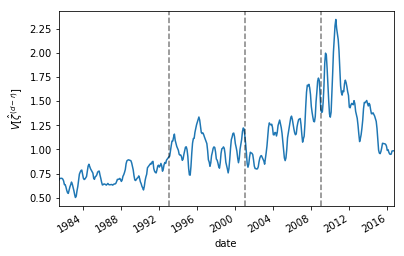

In [63]:
ax = plt.subplot()
var_zeta.plot(ax = ax)
ax.axvline(datetime(year=1993,month=1,day=1),linestyle='--',color='k',alpha=0.5)
ax.axvline(datetime(year=2001,month=1,day=1),linestyle='--',color='k',alpha=0.5)
ax.axvline(datetime(year=2009,month=1,day=1),linestyle='--',color='k',alpha=0.5)
ax.set_ylabel('$V[\hat{\zeta}^{(d-r)}]$');

This is consistent with an increase, particulary in the period at the end of Bush's second term and the beginning of Obama's first term (2007-2011). This coincided with the global financial crisis and associated stimulus and recovery programs, as well as the passage of the Affordable Care Act ("Obamacare").

# Some simple baselines

We can compute several baselines from the (smoothed) frequencies $\fi_w$. One approach is to take norms of the difference between the frequency distributions:

\begin{align}
L_1 = &{} \sum_w |\fi_w - \fj_w|\\
L_2 = &{} \sqrt{\sum_w (\fi_w - \fj_w)^2}.
\end{align}

## Information theory baselines

A slightly more complex baseline is the Jensen-Shannon (JS) divergence, which in turn is based on the Kullback-Leibler (KL) divergence:

\begin{align}
D_{KL}(p, q) = &{} \sum_t p_t \log \frac{p_t}{q_t}\\
JS(\fi, \fj) = &{} \frac{1}{2} D_{KL}(\fi, \overline{f}) + \frac{1}{2} D_{KL}(\fj, \overline{f}),\\
\overline{f} = &{} \frac{1}{2}(\fi + \fj).
\end{align}

The JS divergence is closely related to the log-odds ratio, but does not make use of a prior on the word frequencies.

In [64]:
# distance metrics
l2_norm = lambda t1, t2: np.sqrt(((t1 - t2)**2).sum())
l1_norm = lambda t1, t2: np.abs(t1-t2).sum()
kl_div = lambda t1, t2: t1.dot(np.log(t1) - np.log(t2))
js_div = lambda t1, t2: .5 * (kl_div(t1, .5 * (t1 + t2)) + kl_div(t2, .5 * (t1 + t2)))

In [65]:
smoother = .5 # simple Laplace smoothing

def counts_to_probs(counts):
    assert(len(counts.shape)==1)
    
    probs = counts + smoother
    return probs / probs.sum()

def compute_dists(distance, df):
    dates = []
    dists = []
    for date,local_stats in df.groupby('date'):
        d_vec = counts_to_probs(local_stats['d_count'].to_numpy())
        r_vec = counts_to_probs(local_stats['r_count'].to_numpy())
        
        dists.append(distance(d_vec, r_vec))
        dates.append(date)
    
    df_out = pd.DataFrame({'date':dates, 'distance': dists})

    # apply exponentially weighted smoothing to the output
    df_out['dist_smoothed'] = df_out['distance'].rolling(6).mean().ewm(alpha=alpha_per_month).mean()
    return df_out

## Plotting baseline measures

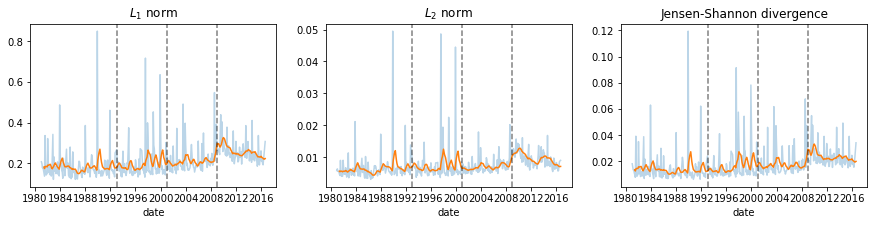

In [66]:
_,axes = plt.subplots(1,3,figsize=[15,3])
for ax, dist, title in zip(axes, [l1_norm, l2_norm, js_div], 
                           ['$L_1$ norm', '$L_2$ norm', 'Jensen-Shannon divergence']):
    df_dist = compute_dists(dist, df_agg)
    sns.lineplot(x='date',y='distance',data=df_dist,ax=ax, alpha =0.3);
    sns.lineplot(x='date',y='dist_smoothed',data=df_dist,ax=ax);
    ax.set_title(title)

    ax.axvline(datetime(year=1993,month=1,day=1),linestyle='--',color='k',alpha=0.5) # beginning of Clinton (D) presidency
    ax.axvline(datetime(year=2001,month=1,day=1),linestyle='--',color='k',alpha=0.5) # beginning of Bush II (R)
    ax.axvline(datetime(year=2009,month=1,day=1),linestyle='--',color='k',alpha=0.5) # beginning of Obama (D)
    ax.set_ylabel('');

To be fair, these figures might look better if the methods were applied to the temporally-smoothed counts rather than using simple Laplace smoothing. Nonetheless, the $L_1$ norm and Jensen-Shannon divergence also suggest an increase in partisanship in the beginning of Obama's first term.

# Extensions

- MCQ argue that an informative Dirichlet prior gives better estimates of the log-odds ratio than the symmetric prior that is typically used, e.g., in topic modeling work. Recompute the results above using a symmetric prior and see if they are significantly changed.
- Examine the impact of temporal smoothing on the overall partisanship trends. Do other smoothers give different results?
- The aggregate partisanship figure in the previous section seems to have some "high frequency" component that varies throughout the year. Try to identify and explain this component.
- Use multiple regression to test the impact of exogeneous political factors such as the timing of elections and split party control of the legislature and presidency.